# Iceland Aerial Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hipp
import os

## Settings

In [3]:
PROJECT_DIRECTORY = "data\iceland\aerial\1980_08_22"
RAW_IMAGES = os.path.join(PROJECT_DIRECTORY, "raw_images")
PREPROCESSED_IMAGES = os.path.join(PROJECT_DIRECTORY, "preprocessed_images")

QUICKVIEW_FACTOR = 0.20

## The Dataset

The dataset consists of **46 aerial photographs** captured using a **Wild RC10 camera** ([calibration report](data/metadata/iceland_aerial/calibration_report.pdf)). The images were acquired on **August 22, 1980**, and cover the **South Iceland**.

They are available for download via the ftp of Joaquin.


In [4]:
!wget -c -r -np -nd -A "*.tif" -P {RAW_IMAGES} https://ftp.lmi.is/.stm/joaquin/history/iceland/aerial_images/19800822/raw_images/


'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [20]:
history.dataquery.download_iceland_aerial_metadata(PROJECT_DIRECTORY)
hipp.tools.generate_quickviews(RAW_IMAGES, QUICKVIEW_FACTOR, max_workers=8)

Generating quickviews:   0%|          | 0/46 [00:00<?, ?image/s]

Generating quickviews: 100%|██████████| 46/46 [00:01<00:00, 26.91image/s]


In [8]:
preproc = hipp.AerialPreprocessing(RAW_IMAGES, PREPROCESSED_IMAGES)

In [13]:
preproc.create_fiducial_template(distance_around_fiducial=70,corner=True)

Fiducials detection:   0%|          | 0/46 [00:00<?, ?it/s]

Fiducials detection: 100%|██████████| 46/46 [00:08<00:00,  5.32it/s]


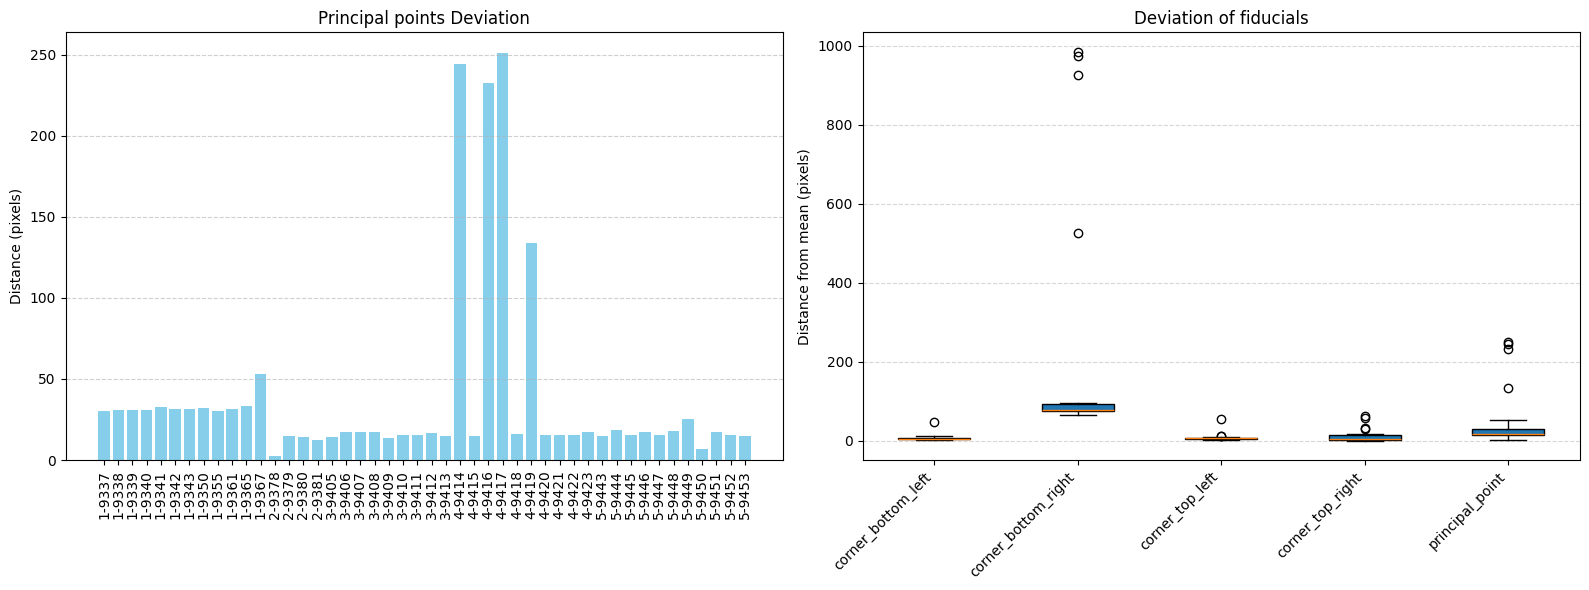

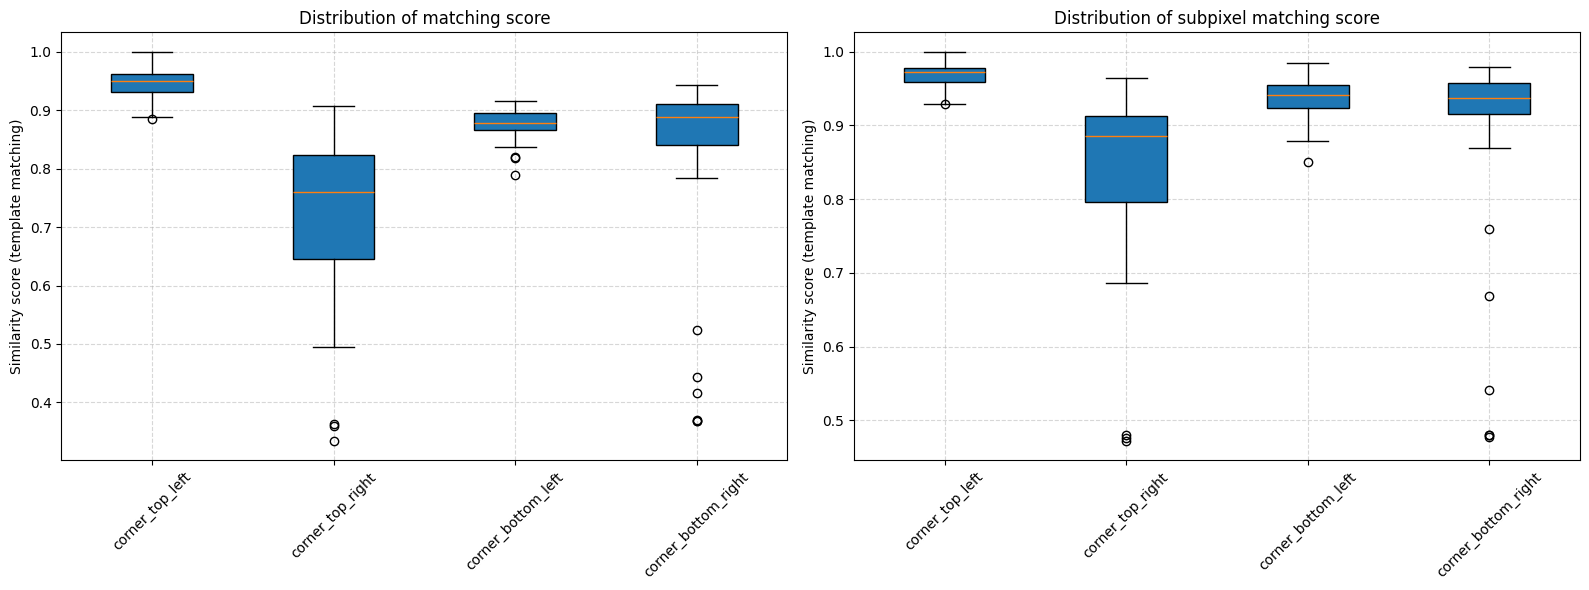

In [14]:
all_detections, all_scores, all_subpixel_scores = preproc.detect_fiducials(grid_size=7)

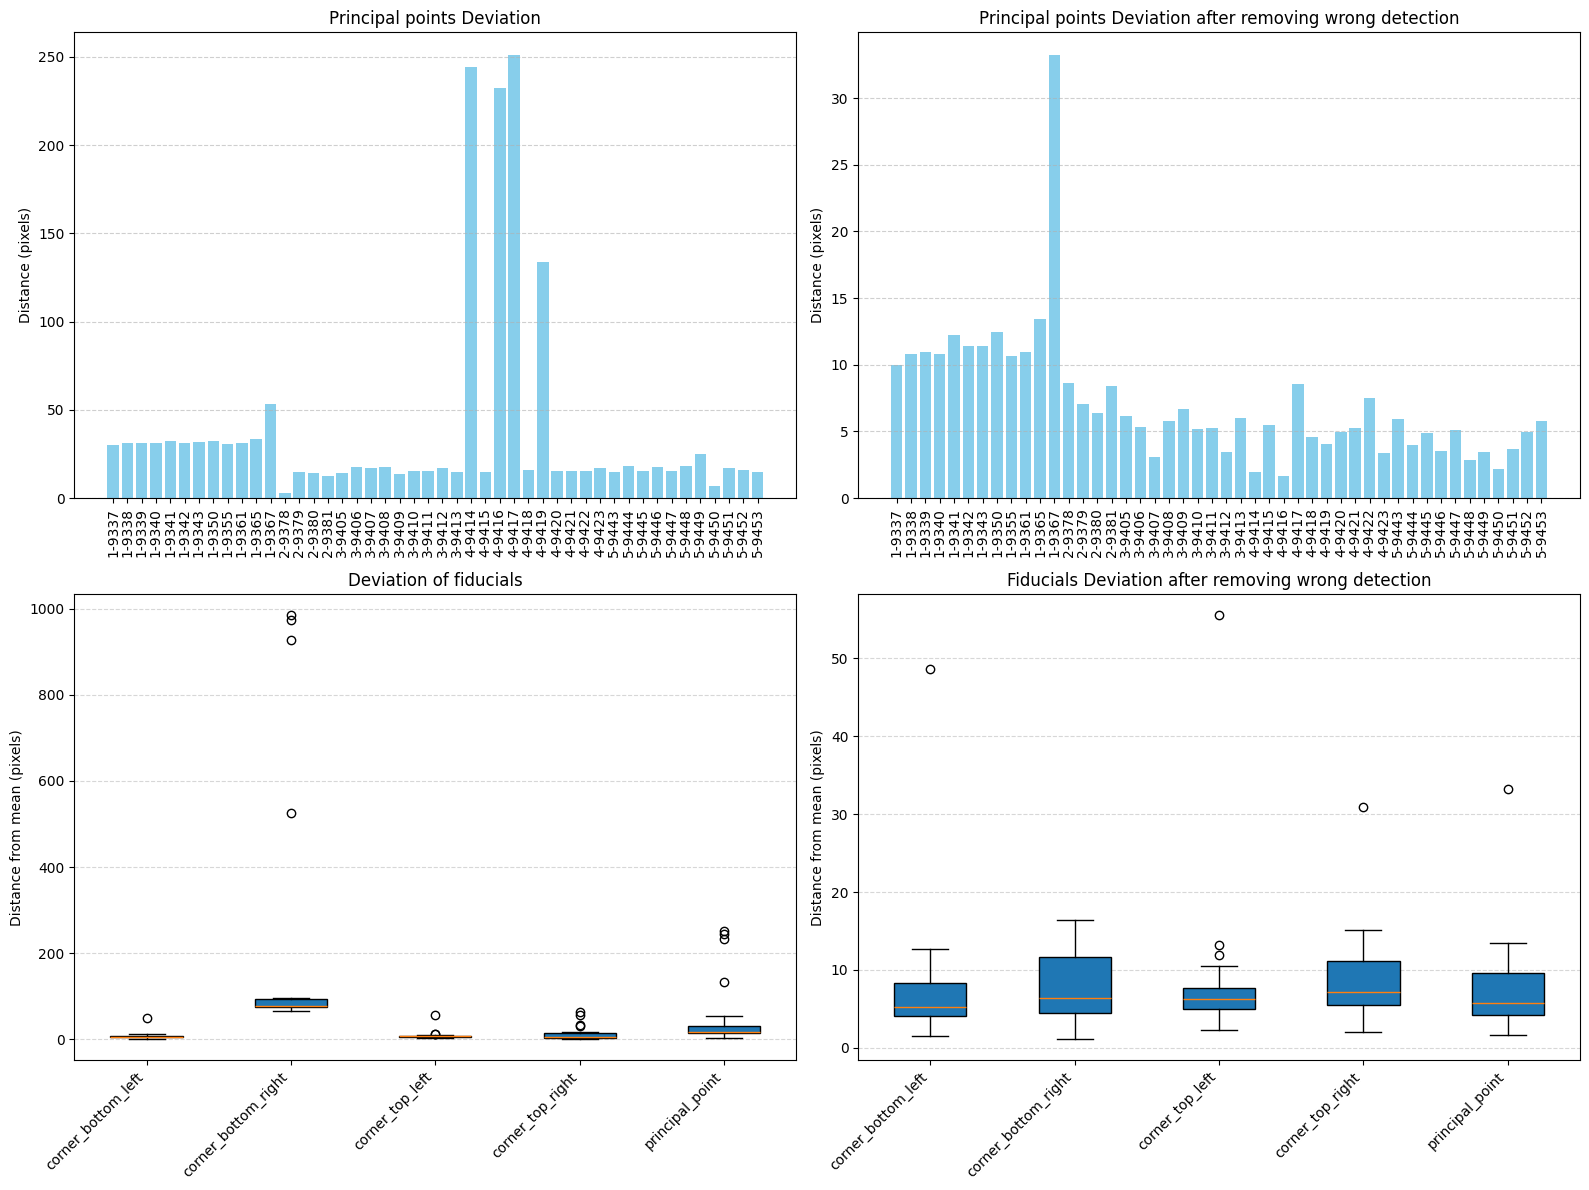

In [15]:
filtered_detections = preproc.filter_detected_fiducials(all_detections, all_scores, all_subpixel_scores, degree_threshold=0.005)
hipp.aerial.detected_fiducials_to_csv(filtered_detections, os.path.join(RAW_IMAGES, "detected_fiducial_markers.csv"))

In [16]:
true_fiducials_mm = {
    "corner_bottom_left": (-106.000, 106.004), # 1
    "corner_top_left": (-106.001, -106.004), # 2
    "corner_top_right": (106.003, -106.007), # 3
    "corner_bottom_right": (105.993, 105.997), # 4
}
# here we inverse y axis cause in the calibration report y axis go down instead of going up
true_fiducials_mm = {key : (x, -y) for key, (x, y) in true_fiducials_mm.items()}

Generating quickviews: 100%|██████████| 46/46 [00:01<00:00, 33.12image/s]


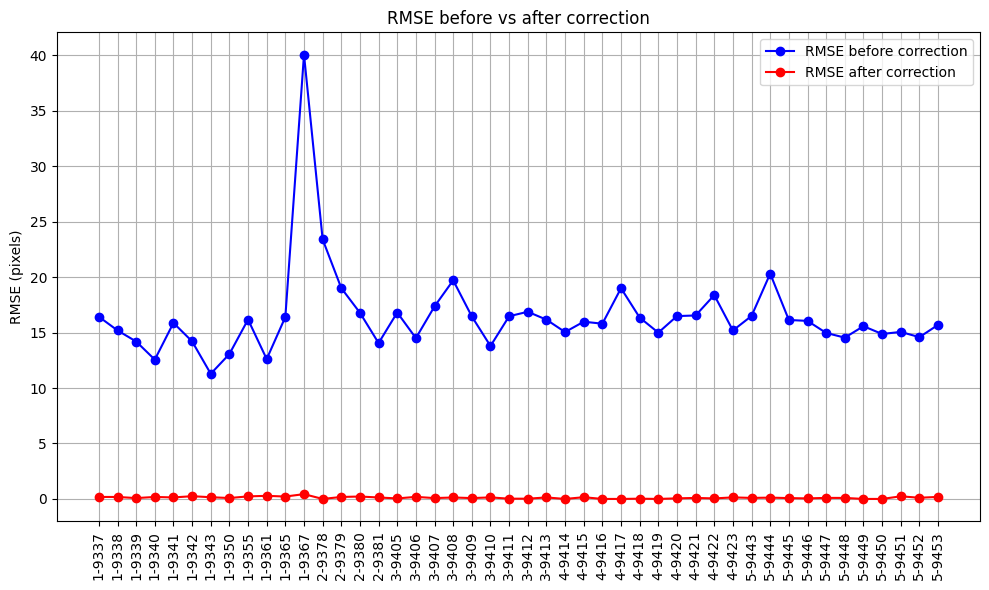

In [19]:
transformation_matrixs = preproc.images_restitution(
    filtered_detections,
    true_fiducials_mm,
    image_square_dim=10600, # this parameters can be calculated, if i want a 212 mm images then i convert in pixels with 212 / scanning_resolution_mm
    scanning_resolution_mm=0.02,
    max_workers=8,
    dry_run=False # set this option to False to transform images 
)
hipp.tools.generate_quickviews(PREPROCESSED_IMAGES, QUICKVIEW_FACTOR, max_workers=8)
transformed_detections = {k: v.transform(transformation_matrixs[k]) for k, v in filtered_detections.items()}

# we can save the transformed detections in a csv file if we want
hipp.aerial.detected_fiducials_to_csv(transformed_detections, os.path.join(PREPROCESSED_IMAGES, "detected_fiducial_markers.csv"))

In [21]:
transformation_matrixs

{'/home/godinlu/Documents/history-dataset-v2/iceland/aerial/1980_08_22/raw_images/1-9342.tif': array([[ 1.00049687e+00, -1.88613696e-03, -1.42015103e+03],
        [ 1.78824490e-03,  1.00043192e+00, -6.80735631e+02],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 '/home/godinlu/Documents/history-dataset-v2/iceland/aerial/1980_08_22/raw_images/1-9350.tif': array([[ 1.00048563e+00, -1.74452074e-03, -1.42291858e+03],
        [ 1.61121308e-03,  1.00045608e+00, -6.81691005e+02],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 '/home/godinlu/Documents/history-dataset-v2/iceland/aerial/1980_08_22/raw_images/1-9343.tif': array([[ 1.00048050e+00, -1.50253768e-03, -1.42033009e+03],
        [ 1.35741868e-03,  1.00045095e+00, -6.77947112e+02],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 '/home/godinlu/Documents/history-dataset-v2/iceland/aerial/1980_08_22/raw_images/1-9341.tif': array([[ 1.00048417e+00, -2.12223467e-03, -1.41665575e+03],
        